# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2.4.1
True


## Функции загрузки данных

In [2]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('data/train_sample/*.jpg')
test_files = glob('data/test_sample/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [1]:
[letter for letter in 'dfsdf']

['d', 'f', 's', 'd', 'f']

## Визуализируем примеры для обучения

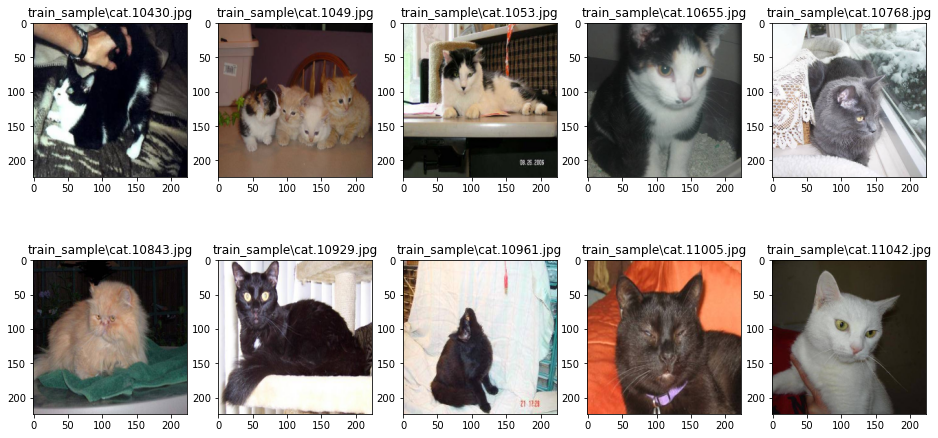

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

In [4]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [5]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Добавляем полносвязный слой

In [6]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

## Выводим архитектуру модели

In [7]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

## Компилируем модель и запускаем обучение

In [8]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [9]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 25s 2s/step - loss: 317.1974 - accuracy: 0.6284 - val_loss: 69.0730 - val_accuracy: 0.8000
Epoch 2/100
10/10 [==============================] - 24s 2s/step - loss: 1.3632 - accuracy: 0.9814 - val_loss: 217.3938 - val_accuracy: 0.8000
Epoch 3/100
10/10 [==============================] - 23s 2s/step - loss: 0.0487 - accuracy: 1.0000 - val_loss: 164.5453 - val_accuracy: 0.8000
Epoch 4/100
10/10 [==============================] - 24s 2s/step - loss: 0.0506 - accuracy: 1.0000 - val_loss: 143.7064 - val_accuracy: 0.8000
Epoch 5/100
10/10 [==============================] - 24s 2s/step - loss: 0.0514 - accuracy: 1.0000 - val_loss: 135.5743 - val_accuracy: 0.8000
Epoch 6/100
10/10 [==============================] - 24s 2s/step - loss: 0.0517 - accuracy: 1.0000 - val_loss: 132.4596 - val_accuracy: 0.8000
Epoch 7/100
10/10 [==============================] - 24s 2s/step - loss: 0.0518 - accuracy: 1.0000 - val_loss: 131.2691 - val_accuracy: 0.800

Epoch 58/100
10/10 [==============================] - 30s 3s/step - loss: 0.0516 - accuracy: 1.0000 - val_loss: 129.9483 - val_accuracy: 0.8000
Epoch 59/100
10/10 [==============================] - 31s 3s/step - loss: 0.0516 - accuracy: 1.0000 - val_loss: 129.9304 - val_accuracy: 0.8000
Epoch 60/100
10/10 [==============================] - 31s 3s/step - loss: 0.0516 - accuracy: 1.0000 - val_loss: 129.9212 - val_accuracy: 0.8000
Epoch 61/100
10/10 [==============================] - 29s 3s/step - loss: 0.0516 - accuracy: 1.0000 - val_loss: 129.8907 - val_accuracy: 0.8000
Epoch 62/100
10/10 [==============================] - 28s 3s/step - loss: 0.0516 - accuracy: 1.0000 - val_loss: 129.8665 - val_accuracy: 0.8000
Epoch 63/100
10/10 [==============================] - 28s 3s/step - loss: 0.0516 - accuracy: 1.0000 - val_loss: 129.8689 - val_accuracy: 0.8000
Epoch 64/100
10/10 [==============================] - 28s 3s/step - loss: 0.0516 - accuracy: 1.0000 - val_loss: 129.8420 - val_accuracy:

In [15]:
model.save('cats-dogs-vgg16.hdf5')

## Предсказания на проверочной выборке

In [16]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

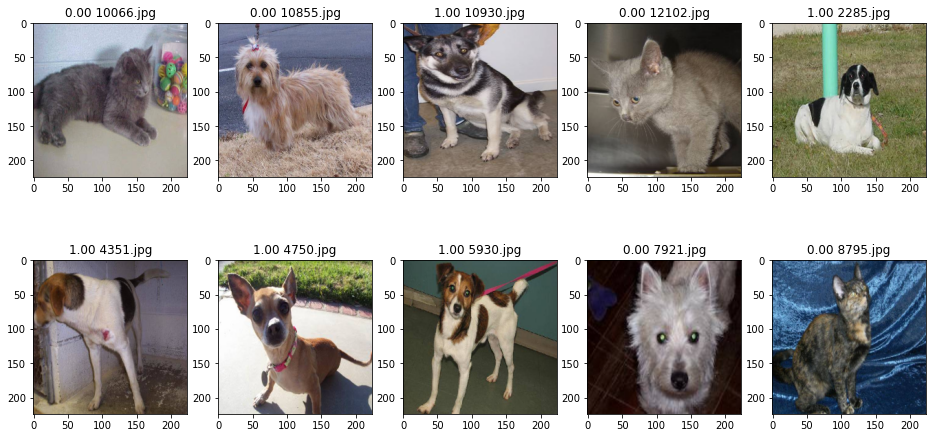

In [17]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [13]:
import re

with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [ ]:
# LogLoss = 1.04979